In [38]:
import os
import pandas as pd
import holidays
import matplotlib.pyplot as plt

In [39]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

In [40]:
start = pd.Timestamp("2017-01-01")
end = pd.Timestamp("2022-03-25")

# Aggregated demand data

In [41]:
def to_datetime(df, col_name):
    try:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))
    except:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y', utc=True))    
    df.index = df.index.date
    df.index = pd.to_datetime(df.index) 
    return df.index

## Trading Hub Europe: SLPs & RLMs

THE original data

In [42]:
#read
the_new = pd.read_csv(os.path.join(data_path, "Trading Hub Europe  Publications  Transparency  Aggregated consumption data.csv"), sep=";")
the_new.index = to_datetime(the_new, "Gasday")

#to numeric
the_new = the_new[the_new.columns[~the_new.columns.isin(["Gastag", "Status", "Gasday", "State"])]].fillna("0")
the_new = the_new.iloc[::-1] 
the_new = the_new.apply(lambda x: x.apply(lambda y: float(y.replace(".", "").replace(",", ""))))

#from kWh to TWh
the_new = the_new / (10**9)

In [6]:
def sum_consumptions(df):
    return pd.concat([
        df[df.filter(like=domain, axis=1).columns].sum(1) for domain in ["SLP", "RLM"]
    ], axis = 1, keys = ["slp", "rlm"]
    )

<AxesSubplot:>

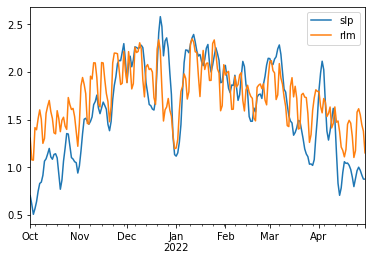

In [7]:
sum_consumptions(the_new).plot()

Gas pool data from: https://www.tradinghub.eu/de-de/Download/Archiv-GASPOOL / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [45]:
gaspool = pd.read_csv(os.path.join(data_path, "gaspool.csv"), sep=";")
gaspool.index = to_datetime(gaspool, "Datum")
gaspool.drop("Datum", axis=1, inplace=True)

#from MWh to TWh
gaspool = gaspool / (10**6)

<AxesSubplot:>

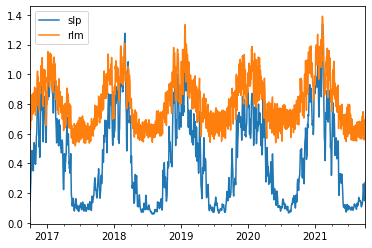

In [9]:
sum_consumptions(gaspool).plot()

NCG data from:https://www.tradinghub.eu/de-de/Download/Archiv-NetConnect-Germany / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [48]:
#in KWh
ncg = pd.read_csv(os.path.join(data_path, "ncg.csv"), sep=";")
ncg.index = to_datetime(ncg, "DayOfUse")

ncg.drop(["DayOfUse", "Status"], axis=1, inplace=True)
ncg.drop(list(ncg.filter(like='Unit', axis=1).columns), axis=1, inplace=True)

#from kWh to TWh
ncg = ncg / (10**9)

<AxesSubplot:>

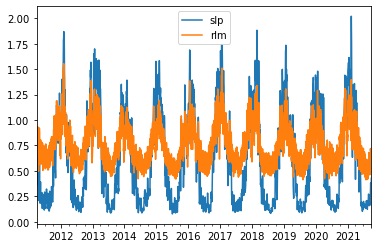

In [11]:
sum_consumptions(ncg).plot()

In [52]:
the = pd.concat([
    sum_consumptions(df) for df in [the_new, gaspool, ncg]
])
the = the.sort_index()
the = the.groupby(the.index).sum()

<AxesSubplot:>

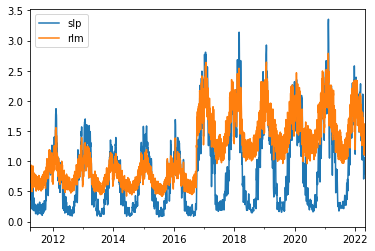

In [13]:
the.plot()

# Proxies / control variables / disaggregated demand
## Estimated SLP (when2heat: w2h)

In [55]:
w2h = pd.read_csv(os.path.join(data_path, "SLPs_new.csv"), index_col=0)
w2h.index = pd.to_datetime(
    pd.to_datetime(w2h.index).date
)
w2h = w2h[w2h.index.year>=2016]

In [75]:
# 2020 has 732 rows --> twice as long as it should be
w2h[w2h.index.year==2020]

,commercial_space TWh,residential_space TWh,commercial_water TWh,residential_water TWh,aggregated(no_dist_heat),dist_heat,aggregated(incl_dist_heat)
2020-01-01,0.779002,1.362830,0.022359,0.151233,2.315424,0.008515,2.323939
2020-01-02,0.785108,1.362669,0.022614,0.151233,2.321625,0.008538,2.330162
2020-01-03,0.644351,1.163007,0.022255,0.151233,1.980846,0.007284,1.988130
2020-01-04,0.552548,1.088521,0.020261,0.151233,1.812564,0.006666,1.819229
2020-01-05,0.559163,1.091601,0.020525,0.151233,1.822522,0.006702,1.829224
...,...,...,...,...,...,...,...
2020-12-27,0.650233,1.280176,0.020531,0.151377,2.102317,0.007731,2.110048
2020-12-28,0.694194,1.248202,0.022530,0.151377,2.116303,0.007782,2.124085
2020-12-29,0.687624,1.237549,0.022559,0.151377,2.099109,0.007719,2.106828
2020-12-30,0.672110,1.222023,0.022355,0.151377,2.067864,0.007604,2.075469


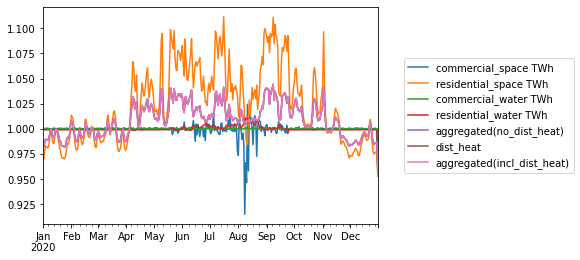

In [76]:
# duplicates are not identical and the relative error varies over time
(w2h[w2h.index.year==2020].iloc[:366] / w2h[w2h.index.year==2020].iloc[366:]).plot()
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))

In [81]:
# drop duplicates for now, but adjusting original data is needed
w2h = w2h[w2h.index.duplicated()==False].copy()

In [82]:
w2h["commercial"] = w2h[["commercial_space TWh", "commercial_water TWh"]].sum(1)
w2h["residential"] = w2h[["residential_space TWh", "residential_water TWh"]].sum(1)

Gas consumption according to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [83]:
def scaling(df, target, target_year=2020): 
    return (df * target / df[df.index.year==target_year].sum()).copy()

In [84]:
w2h_scaled = pd.DataFrame()

scaling_map = {
    'residential': ('residential', 254),
    'commercial': ('commercial', 98),
    'decentral_chp': ('commercial', 15),
    'industry_buildings': ('commercial', 25)
}

for name_out, (name_in, target) in scaling_map.items():
    w2h_scaled[name_out] = scaling(w2h[name_in], target)
    
w2h_scaled['aggregated'] = w2h_scaled[scaling_map.keys()].sum(1)

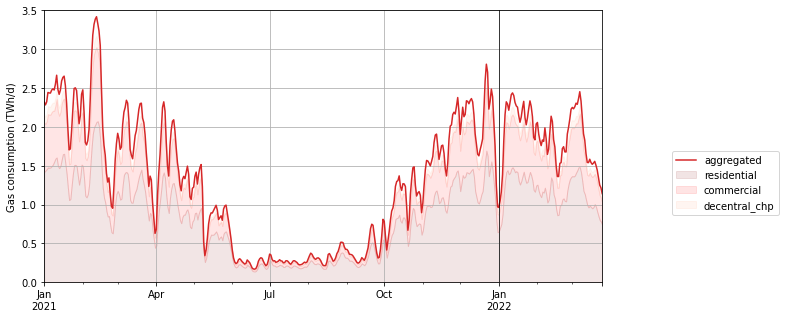

In [85]:
w2h_scaled.loc[w2h_scaled.index.year>=2021,'aggregated'].plot(color='tab:red', figsize=(10,5))
plt.grid()

estimated2021 = w2h_scaled.loc["2021-01-01":]

bottom = 0
for sector, c, label in [
    ("residential", "maroon", "residential"), 
    ("commercial","red", "commercial"), 
    ("decentral_chp", "lightsalmon", "decentral_chp") 
]:
    plt.fill_between(estimated2021.index, bottom, bottom+estimated2021[sector], color=c, alpha=0.1, label = label)
    bottom += estimated2021[sector]

plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.legend(loc='upper right', bbox_to_anchor=(1.325, 0.5))
plt.ylim(0, 3.5)
plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [86]:
electricity_from_gas = pd.read_csv(os.path.join(data_path, "electricity_from_gas.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

electricity_from_gas.index = pd.to_datetime(
    pd.to_datetime(electricity_from_gas.index).date
)
electricity_from_gas = electricity_from_gas /10**6

# earlier data

el_update = pd.read_csv(os.path.join(data_path, "entsoe_new.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]
el_update.index = pd.to_datetime(
    el_update.index.map(lambda x: x.date())
)

# concat

electricity_from_gas = pd.concat([el_update, electricity_from_gas], axis=0)

Scaled to monthly Eurostat data on electricity generation from gas:

In [87]:
monthly_scaling = pd.read_csv(os.path.join(data_path, "nrg_cb_pem__custom_2931753_page_linear.csv"), 
                                   index_col="TIME_PERIOD", parse_dates=True)["OBS_VALUE"]
monthly_scaling.index = monthly_scaling.index = pd.to_datetime(
    pd.to_datetime(monthly_scaling.index).date
)

In [88]:
for date in monthly_scaling.index:
    conditions = ((electricity_from_gas.index.year==date.year) & 
                  (electricity_from_gas.index.month==date.month))
    electricity_from_gas[conditions] = electricity_from_gas[conditions] * monthly_scaling[date] / electricity_from_gas[conditions].sum() 

Scaled to gas consumption for electricity generation: 185 TWh in 2020, which is the sum of public power plants, public CHP, and industrial power plants (probably also mostly CHP)

In [89]:
gas_to_electricity = scaling(electricity_from_gas , 189)

gas_to_electricity_public_pp = scaling(electricity_from_gas, 106)

gas_to_electricity_public_chp = scaling(electricity_from_gas, 34)

electricity_from_gas.name = "electricity_from_gas"    
gas_to_electricity.name = "gas_to_electricity"  

(17167.0, 19076.0)

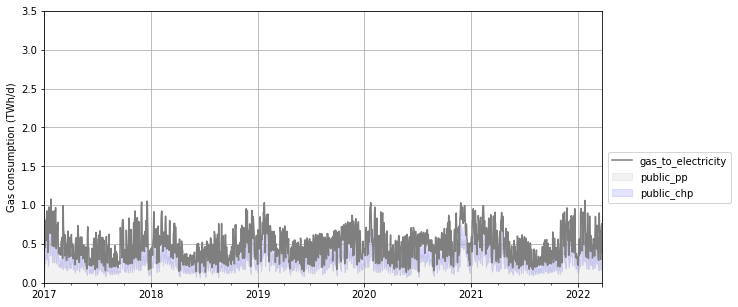

In [90]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()

plt.fill_between(gas_to_electricity_public_pp.index, 
                 0, 
                 gas_to_electricity_public_pp, 
                 color='grey', alpha=0.1, label="public_pp")
plt.fill_between(gas_to_electricity_public_pp.index, 
                 gas_to_electricity_public_pp, 
                 gas_to_electricity_public_pp+gas_to_electricity_public_chp, 
                 color='blue', alpha=0.1, label="public_chp")

plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.5))
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.xlim(left=start, right=end)

## Gas prices

In [108]:
gas_prices = pd.read_csv(os.path.join(data_path, "Dutch TTF Natural Gas Futures Recent.csv"), index_col=0)
gas_prices = gas_prices["Price"].to_frame().rename(columns={
    "Price":"gas_price [€/MWh]"}).dropna()
gas_prices.index = pd.to_datetime(pd.to_datetime(gas_prices.index, utc = True).date)

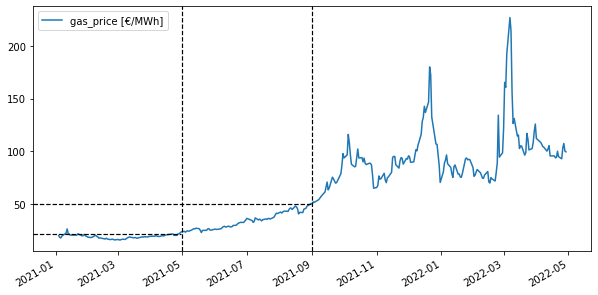

In [109]:
gas_prices.plot(figsize=(10,5))
plt.axvline(x="2021-09-1", color='k', linestyle='--', lw=1.2)
plt.axvline(x="2021-05-1", color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.5, y=50, color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.265, y=21, color='k', linestyle='--', lw=1.2)

In [110]:
def index_allignment(df):
    df.index = pd.DatetimeIndex(df.index)
    df = df.resample("D").mean()
    return df[df.index.duplicated()==False]

## Ambient temperature and solar radiation

In [111]:
# Currently only data from 2020 onwards

temperature = pd.read_csv(os.path.join(data_path, "aggregated_temperature.csv"), index_col=0)
temperature =  index_allignment(temperature)

ref_temperature = pd.read_csv(os.path.join(data_path, "aggregated_reference_temperature.csv"), index_col=0)
ref_temperature = index_allignment(ref_temperature)

solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar = index_allignment(solar)
solar = solar * 2.77778e-7 #J --> kWh
solar = solar.rename(columns={"solar [J/m^2]" : "solar [kWh/m^2]"})

## Producing sector

In [112]:
producing_sector = pd.read_csv(os.path.join(data_path, "manufacturing.csv"), index_col=0, sep=";", dtype={"Kalender- und saisonbereinigt nach X13 JDemetra+":float}, decimal=",")
producing_sector = producing_sector.iloc[:,0] #0: original, 1: adjusted values

producing_sector.index = pd.DatetimeIndex(pd.DatetimeIndex(producing_sector.index).date)
producing_sector = producing_sector.reindex(the.index, method = "ffill")
producing_sector.name = "producing_sector"

<AxesSubplot:>

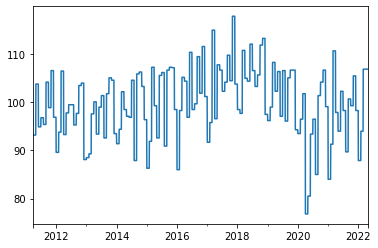

In [113]:
producing_sector.plot()

# Combine data

In [116]:
df = the.join(
    [gas_to_electricity, electricity_from_gas, gas_prices, producing_sector, w2h_scaled]
)

In [117]:
def unify_index(df):
    try:
        return df.loc[(df.index >= start) & (df.index <= end)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [118]:
df = unify_index(df).copy()

In [119]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [120]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [121]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [122]:
df

,slp,rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],producing_sector,residential,commercial,decentral_chp,industry_buildings,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2017-01-01,2.302289,1.673442,0.325731,139.161499,NaN,91.7,1.457936,0.628800,0.096245,0.160408,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-02,2.362777,2.056043,0.549828,234.902217,NaN,91.7,1.423058,0.670494,0.102627,0.171044,...,2017,1,Monday,0,1,0,0,0,0,0
2017-01-03,2.284347,2.030095,0.453608,193.794329,NaN,91.7,1.362678,0.635979,0.097344,0.162240,...,2017,1,Tuesday,1,0,0,0,0,0,0
2017-01-04,2.203892,2.108759,0.465417,198.839085,NaN,91.7,1.305515,0.598531,0.091612,0.152686,...,2017,1,Wednesday,2,0,0,0,0,0,0
2017-01-05,2.509253,2.358004,0.763463,326.173074,NaN,91.7,1.441746,0.680565,0.104168,0.173613,...,2017,1,Thursday,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,1.392489,1.760465,0.571950,244.353213,96.302,106.9,0.909151,0.379785,0.058130,0.096884,...,2022,3,Monday,0,1,0,0,0,0,0
2022-03-22,1.298477,1.775411,0.725432,309.925058,98.745,106.9,0.852247,0.348559,0.053351,0.088918,...,2022,3,Tuesday,1,0,0,0,0,0,0
2022-03-23,1.192763,1.735938,0.749840,320.352790,117.000,106.9,0.802116,0.318578,0.048762,0.081270,...,2022,3,Wednesday,2,0,0,0,0,0,0
2022-03-24,1.139401,1.730537,0.762009,325.551653,111.610,106.9,0.780445,0.309264,0.047336,0.078894,...,2022,3,Thursday,3,0,0,0,0,0,0


# Export

In [37]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))